# Домашнее задание №3

Что требуется сделать:
- собрать свой датасет не менее из 100 фотографий и сделать разметку;
- обучить любую модель с разными техниками аугментации;
- оформить анализ результатов.


In [1]:
import os.path
import os
import random

from tqdm.notebook import tqdm
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
import timm
from sklearn.metrics import accuracy_score
from byol_pytorch import BYOL

## 1 Сборка датасета

Для обучения модели собран датасет с фотографиями двух типов попугаев: Cocktaiel и Cockatoo.
Внешне они несколько похожи, поэтому будет интересно, насколько точно модель сможет отличить одну породу от другой.

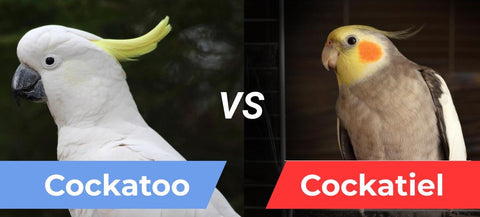

In [2]:
Image.open("cockatoo-vs-cockatiel_large.jpg")

Файл dataset.xlsx содержит размету изображений, а также разбиение на части обучения и теста.
Всего изображений 100. Для каждой породы по 50.

In [3]:
df_parrot = pd.read_excel('dataset.xlsx')
df_parrot

,filename,target,parrot_name,split
0,1.jpg,0,cockatiel,train
1,2.jpg,0,cockatiel,train
2,3.jpg,0,cockatiel,train
3,4.jpg,0,cockatiel,train
4,5.jpg,0,cockatiel,train
...,...,...,...,...
95,96.jpg,1,cockatoo,val
96,97.jpg,1,cockatoo,val
97,98.jpg,1,cockatoo,val
98,99.jpg,1,cockatoo,val


## 2 Создание вспомогательных функций и классов

In [4]:
def set_seed(seed=None, seed_torch=True):
    """ Фиксируем генератор случайных чисел
    
    Параметры
    ---------
    seed : int
    seed_torch : bool
      Если True, то будет зафиксирован PyTorch
    """
    
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [5]:
class ImageTransform(nn.Module):
    """ Базовый класс для трансформации изображений на основе Albumentations
    """
    def __init__(self):
        
        super().__init__()
        self._transforms = A.Compose([])
        
    def forward(self, image):
        return self._transforms(image=image)['image'].type(torch.float32)
    
    def add_transform(self, transform, index=0):
        """ Добавить преобразование
        
        Параметры
        ---------
        transform : albumentations transform
          Инициализированный класс преобразования albumentations
        index : int
          Позиция для вставки в текущие преобразования.
          По умолчанию 0.
        """
        assert isinstance(index, int)
        new_transforms = []
        for idx, c_transform in enumerate(self._transforms):
            if index == idx:
                new_transforms.append(transform)
            new_transforms.append(c_transform)
        self._transforms = A.Compose(new_transforms)
        
    def delete_transform(self, index):
        """ Удалить преобразование
        
        Параметры
        ---------
        index : int или list
          Индекс или список индексов аугментаций для удаления
        """
        assert isinstance(index, int)
        new_transforms = []
        for idx, c_transform in enumerate(self._transforms):
            if idx == index or idx in index:
                continue
            new_transforms.append(c_transform)
        self._transforms = A.Compose(new_transforms)
        
    def __repr__(self):
        return(str(self._transforms))
    
    def __str__(self):
        return(str(self._transforms))

In [6]:
class BaseImageTransform(ImageTransform):
    """ Класс с минимальными преобразованиями, которые можно использовать
    как для обучения, так и для валидации.
    
    - Изменение размера изображения
    - Нормализация изображения с параметрами от ImageNet
    - Преобразование изображения в тензор PyTorch
    - Преобразование значений изображения в тип torch.float32
    
    Параметры
    ---------
    height : int
      Высота изображения для операции Resize
    width : int
      Ширина изображения для операции Resize
    """
    def __init__(self, height=224, width=224):
        
        super().__init__()
        
        # Средние значения для IMAGE NET, используются при стандартизации изображений
        IMAGENET_MEAN = [0.485, 0.456, 0.406]
        # СКО для IMAGE NET, используются при стандартизации изображений
        IMAGENET_STD = [0.229, 0.224, 0.225]
        
        self._transforms = A.Compose([
            A.Resize(height, width),
            A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
            ToTensorV2(),
        ])

In [7]:
class ParrotDataSet(Dataset):
    """ Датасет Cockatiel VS Cockatoo
    
    Параметры
    ---------
    parrot_df : pandas dataframe
      Общий датафрейм с данными (обучение + тест).
      Датафрейм должен обязательно содержать следующие колонки:
      - filename (название файла изображения)
      - target (целевая метка в виде числа)
      - parrot_name (порода попугая)
      - split (используется для разделения данных по выборкам,
               принимает значения train или val)
    photo_dir : str
      Путь к папке с изображениями.
    image_size : int
      Размер выходного изображения для генерации датасета.
      По умолчанию 224.
    train_transforms : BaseImageTransform
      Набор преобразований изображения для обучения
    val_transforms : BaseImageTransform
      Набор преобразований изображения для тестирования
    seed : int
      Фиксация генератора случайных чисел.
    """

    def __init__(self, parrot_df, train_transforms=None, val_transforms=None, 
                 seed=None):

        if seed is not None:
            set_seed(seed)

        assert 'filename' in parrot_df.columns, "Датафрейм parrot_df должен содержать колонку filename"
        assert 'target' in parrot_df.columns, "Датафрейм parrot_df должен содержать колонку target"
        assert 'split' in parrot_df.columns, "Датафрейм parrot_df должен содержать колонку split"
        assert 'parrot_name' in parrot_df.columns, "Датафрейм parrot_df должен содержать колонку parrot_name"

        self._parrot_df = parrot_df

        self._train_df = parrot_df[parrot_df.split == 'train'].copy()
        self._train_size = len(self._train_df)
        self._val_df = parrot_df[parrot_df.split == 'val'].copy()
        self._val_size = len(self._val_df)
        
        self._train_transforms = train_transforms
        self._val_transforms = val_transforms
            
        self._lookup_dict = {
            'train': (self._train_df, self._train_size, train_transforms),
            'val': (self._val_df, self._val_size, val_transforms),
        }
        
        # По умолчанию включаем режим обучения
        self.set_split('train')

    def set_split(self, split='train'):
        """ Выбор режима датасета
        
        Параметры
        ---------
        split : str
          Выбор режима train или val
        """
        split = str(split).strip().lower()
        assert split in ('train', 'val'), "split может принимать значения train или val"

        self._target_split = split
        self._target_df, self._target_size, self._target_transforms = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """ Возвращает элемент датасета в формате:
        {
        'x_data': Тензор изображения размером N x C x H x W,
        'target': числовая метка
        }
        """

        # Получаем строку датафрейма по его индексу
        row = self._target_df.iloc[index, :]

        # Словарь, который будем возвращать
        model_data = {}

        # Формируем ссылку к изображению и проверяем на доступность файла
        image_path = row.filename
        if not os.path.exists(image_path):
            raise Exception(f"Файл {image_path} не существует")

        # Читаем изображение и применяем функцию обработки изображения
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self._target_transforms is not None:
            img = self._target_transforms(image=img)

        # Добавляем в возвращаемый словарь обработанное изображение
        model_data['img'] = img
        # Добавляем в возвращаемый словарь путь к исходному изображению
        model_data['image_path'] = image_path
        # Целевая метка
        model_data['target'] = row.target
        # Название породы попугая
        model_data['parrot_name'] = row.parrot_name
        
        return model_data

In [8]:
class ParrotDataLoader(pl.LightningDataModule):
    """ Загрузчик PyTorch Lighting для датасета ParrotDataSet
    
    Параметры
    ---------
    parrot_df : pandas dataframe
      Общий датафрейм с данными (обучение + тест).
      Датафрейм должен обязательно содержать следующие колонки:
      - filename (полный пусть к файлу изображения)
      - target (целевая метка в виде числа)
      - parrot_name (порода попугая)
      - split (используется для разделения данных по выборкам,
               принимает значения train или val)
    train_loader_params : dict
      Словарь для параметров DataLoader обучающего датасета.
      Имеет следующие ключи:
        - batch_size (по умолчанию 16)
        - shuffle (по умолчанию True)
        - num_workers (по умолчанию 2)
        - drop_last (по умолчанию True)
    val_loader_params : dict
      Словарь для параметров DataLoader валидационного датасета.
      Имеет следующие ключи:
        - batch_size (по умолчанию 16)
        - shuffle (по умолчанию False)
        - num_workers (по умолчанию 2)
        - drop_last (по умолчанию False)
    dataset_params : dict
      Словарь для создания экземпляров ParrotDataSet
      Предназначен для передачи разных типов аугментаций.
      Должен содержать все следующие ключи или один из:
        - train_transforms (по умолчанию None, передается экземпляр BaseImageTransform)
        - val_transforms (по умолчанию None, передается экземпляр BaseImageTransform)
    seed : int
      Фиксация генератора случайных чисел.
    """

    def __init__(self, parrot_df, train_loader_params=None, val_loader_params=None,
                 dataset_params=None, seed=None):

        super().__init__()

        if seed is not None:
            set_seed(seed)

        self._parrot_df = parrot_df

        if not train_loader_params:
            train_loader_params = {
                'batch_size': 16,
                'shuffle': True,
                'num_workers': 2,
                'drop_last': True,
            }

        if not val_loader_params:
            val_loader_params = {
                'batch_size': 16,
                'shuffle': False,
                'num_workers': 2,
                'drop_last': False
            }

        if not dataset_params:
            dataset_params = {
                'train_transforms': None,
                'val_transforms': None,
            }

        self.train_loader_params = train_loader_params
        self.val_loader_params = val_loader_params
        self._dataset_params = dataset_params

        self.make_split_dict()

    def make_split_dict(self):

        self.train_dataset = ParrotDataSet(parrot_df=self._parrot_df, **self._dataset_params)
        self.train_dataset.set_split('train')

        self.val_dataset = ParrotDataSet(parrot_df=self._parrot_df, **self._dataset_params)
        self.val_dataset.set_split('val')


    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.train_loader_params['batch_size'],
                          shuffle=self.train_loader_params['shuffle'], drop_last=self.train_loader_params['drop_last'],
                          num_workers=self.train_loader_params['num_workers'])

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.val_loader_params['batch_size'],
                          drop_last=self.val_loader_params['drop_last'], shuffle=self.val_loader_params['shuffle'],
                          num_workers=self.val_loader_params['num_workers'])
    

    @classmethod
    def create_loader(cls, parrot_xlsx, photo_dir, train_loader_params=None, val_loader_params=None,
                              dataset_params=None, seed=None):   
        """
        Создание экземпляра класса загрузчика ParrotDataLoader
        
        Изначально в файле разметки нет полного пути к фото, функция дополняет ипя файла полным путем к нему 
        и возвращает инициализированный класс ParrotDataLoader
        
        Параметры
        ---------
        parrot_xlsx : str
          Пусть к файлу train.csv
        photo_dir : str
          Путь к папке с фото для обучения
        train_loader_params : dict
          Словарь для параметров DataLoader обучающего датасета. 
          См. код инициализации класса.
        val_loader_params : dict
          Словарь для параметров DataLoader валидационного датасета. 
          См. код инициализации класса.
        dataset_params : dict
          Словарь для создания экземпляров ParrotDataSet
          См. код инициализации класса.
        seed : int
          Фиксация генератора случайных чисел.
        Результат
        ---------
        parrotdataloader : ParrotDataLoader
        """     

        parrot_df = pd.read_excel(parrot_xlsx)
        
        if os.path.sep != photo_dir[-1]:
            photo_dir += os.path.sep
            
        parrot_df.filename = parrot_df.filename.apply(lambda x: photo_dir + x)
        
        return cls(parrot_df=parrot_df, train_loader_params=train_loader_params, val_loader_params=val_loader_params,
                   dataset_params=dataset_params, seed=seed)

In [9]:
class ParrotModel(pl.LightningModule):
    """ Модель для датасета Cockatiel VS Cockatoo
    
    Параметры
    ---------
    model_name : str
      Название модели (должен поддерживать фреймворк timm).
      По умолчанию resnet18
    pretrained : bool
      Если True, то будут загружены веса для предварительно обученной модели
      По умолчанию True.
    learning_rate : float
      Скорость обучения модели. По умолчанию 0.001.
    l2_regularization : float
      Размер L2-регуляризации, по умолчанию 0.01
    adam_betas : tuple
      Коэффициенты для оптимизатора Adam.
      По умолчанию (0.99, 0.999).
    plot_epoch_loss : bool
      Если True, то после каждой эпохи обучения и валидации будет выводиться график с результатами обучения
    seed : int
    """
    def __init__(self, model_name='resnet18', pretrained=True, learning_rate=0.001, 
                 l2_regularization=0.01, adam_betas=(0.99, 0.999), plot_epoch_loss=True, seed=None):
        
        super().__init__()
        
        if seed is not None:
            set_seed(seed)
        
        self._model = timm.create_model(model_name, pretrained=pretrained, num_classes=1)
        
        self.plot_epoch_loss = plot_epoch_loss
        self.learning_rate = learning_rate
        self.l2_regularization = l2_regularization
        self.adam_betas = adam_betas
        
        # Словарь для хранения значения ошибок на стадии обучения и валидации
        # Для значений типа train добавляем значение np.nan, так как при первом запуске модель вначале осуществляет
        # шаг валидации без обучения и добавляет значения в списки типа val. Это будет считаться эпохой №0.
        self.train_history = {
            'train_loss': [np.nan],
            'train_acc': [np.nan],
            'val_loss': [],
            'val_acc': [],
        }

        self.save_hyperparameters()
        
    def forward(self, x_in, sigmoid=True):
        forward_data = self._model(x_in)
        if sigmoid:
            forward_data = torch.sigmoid(forward_data)
        return forward_data

    def configure_optimizers(self):
        """Конфигурация оптимизатора и планировщика скорости обучения"""
        optimizer = optim.AdamW(self.parameters(), betas=self.adam_betas, lr=self.learning_rate,
                                weight_decay=self.l2_regularization)
        sheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                  T_0=20,
                                                                  eta_min=1e-4)

        return [optimizer], [sheduler]

    def _share_step(self, batch, batch_idx, mode='train'):
        """ Общий шаг для обучения, валидации и теста
        Параметры
        ---------
        batch : dict
          Батч-словарь в следующем формате:
          {
          'img': список тензоров изображения размером N x C x H x W,
          'image_path': список путей к файлам изображений,
          'target': список целевых значений,
          'parrot_name': список человекочитаемых имен попугаев,
          }
        batch_idx : int
          Номер батча
        mode : str
          Режим. Используется только для префикса названий ошибок в логе.
          По умолчанию train
        """

        # Получаем предсказанные метки
        target_pred = self(batch['img'])
        target_true = batch['target'].float()

        # Считаем ошибку Binary Cross Entropy и логируем ее
        bce_loss = F.binary_cross_entropy(target_pred.flatten(), target_true)
        self.log(f'bce_{mode}_loss', bce_loss, prog_bar=True)
        
        acc_loss = accuracy_score(target_true.cpu(), np.where(target_pred.flatten().cpu() > 0.5, 1, 0))
        self.log(f'acc_{mode}_loss', acc_loss, prog_bar=True)

        return {'loss': bce_loss, 'acc_loss': acc_loss}

    def training_step(self, batch, batch_idx):
        """Шаг обучения"""
        return self._share_step(batch, batch_idx, mode='train')

    def training_epoch_end(self, outputs):
        """Действия после окончания каждой эпохи обучения
        Параметры
        ---------
        outputs : list
          Список словарей. Каждый словарь - результат функции self._share_step для определенного батча на шаге обучения
        """

        # Считаем средние ошибки loss и acc_loss по эпохе
        avg_train_loss = torch.tensor([x['loss'] for x in outputs]).detach().mean()
        avg_acc_loss = torch.tensor([x['acc_loss'] for x in outputs]).detach().mean()

        # Добавляем средние ошибки в словарь статистики обучения, используется для построение графиков
        self.train_history['train_loss'].append(avg_train_loss.numpy().item())
        self.train_history['train_acc'].append(avg_acc_loss.numpy().item())

        # Если включено отображение графика обучения в конце эпохи, то рисуем графики
        if self.plot_epoch_loss:
            self.plot_history_loss()

    def validation_step(self, batch, batch_idx):
        """ Шаг валидации """
        return self._share_step(batch, batch_idx, mode='val')

    def validation_epoch_end(self, outputs):
        """Действия после окончания каждой эпохи валидации
        Параметры
        ---------
        outputs : list
          Список словарей.
          Каждый словарь - результат функции self._share_step для определенного батча на шаге валидации
        """

        # Считаем средние ошибки loss и rmse_loss по эпохе
        avg_val_loss = torch.tensor([x['loss'] for x in outputs]).detach().mean()
        avg_acc_loss = torch.tensor([x['acc_loss'] for x in outputs]).detach().mean()
        
        # Логируем ошибку валидации
        self.log(f'val_loss', avg_val_loss, prog_bar=True)

        # Добавляем средние ошибки в словарь статистики обучения, используется для построение графиков
        self.train_history['val_loss'].append(avg_val_loss.numpy().item())
        self.train_history['val_acc'].append(avg_acc_loss.numpy().item())

        # Если включено отображение графика обучения в конце эпохи, то рисуем графики
        if self.plot_epoch_loss:
            self.plot_history_loss()

    def plot_history_loss(self, clear_output=True):
        """ Функция построения графика обучения в конце эпохи
        
        Параметры
        clear_output : bool
          Если True, то после каждой эпохи график будет обновляться,
          а не печататься новый.
        """

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(np.arange(0, len(self.train_history['train_loss'])),
                     self.train_history['train_loss'],
                     label="train_loss")
        axes[0].scatter(np.arange(0, len(self.train_history['train_loss'])),
                     self.train_history['train_loss'])
        axes[0].plot(np.arange(0, len(self.train_history['val_loss'])),
                     self.train_history['val_loss'],
                     label="val_loss")
        axes[0].scatter(np.arange(0, len(self.train_history['val_loss'])),
                     self.train_history['val_loss'])
        axes[0].legend(loc='best')
        axes[0].set_xlabel("epochs")
        axes[0].set_ylabel("loss")
        if len(self.train_history['val_loss'])> 1:
            val_loss_epoch_min = np.argmin(self.train_history['val_loss'][1:]) + 1
            val_loss_min = self.train_history['val_loss'][val_loss_epoch_min]
            val_loss_min = round(val_loss_min, 3) if not np.isnan(val_loss_min) else val_loss_min
            title_min_vals = f'\nValidation minimum {val_loss_min} on epoch {val_loss_epoch_min}'
        else:
            title_min_vals = ""
        axes[0].set_title('MODEL LOSS: BCE'+title_min_vals)
        axes[0].grid()

        axes[1].plot(np.arange(0, len(self.train_history['train_acc'])),
                     self.train_history['train_acc'], label="train_acc")
        axes[1].scatter(np.arange(0, len(self.train_history['train_acc'])),
                     self.train_history['train_acc'])
        axes[1].plot(np.arange(0, len(self.train_history['val_acc'])),
                     self.train_history['val_acc'], label="val_acc")
        axes[1].scatter(np.arange(0, len(self.train_history['val_acc'])),
                     self.train_history['val_acc'])
        axes[1].legend(loc='best')
        axes[1].set_xlabel("epochs")
        axes[1].set_ylabel("accuracy")
        
        if len(self.train_history['val_acc'])> 1:
            val_acc_epoch_max = np.argmax(self.train_history['val_acc'][1:]) + 1
            val_acc_max = self.train_history['val_acc'][val_acc_epoch_max]
            val_acc_max = round(val_acc_max, 3) if not np.isnan(val_acc_max) else val_acc_max
            title_max_vals = f'\nValidation maximum {val_acc_max} on epoch {val_acc_epoch_max}'
        else:
            title_max_vals = ""
        axes[1].set_title('MONITORING LOSS: Accuracy'+title_max_vals)
        axes[1].grid()

        plt.show()
        if clear_output:
            display.clear_output(wait=True)

In [10]:
def print_aug_img(dataloader: ParrotDataLoader, transforms: A.Compose):
    """ Функция для печати 16 примеров аугментации
    В dataloader используется нормализация изображения,
    поэтому из загрузчика будет браться только путь к файлу для чтения оригинала.
    
    В transforms следуюет передать все необходимые аугментации для демонстрации
    """
    
    number_images = 12
    
    backup_batch_size = dataloader.train_loader_params['batch_size']
    dataloader.train_loader_params['batch_size'] = 1
    
    fig, axes = plt.subplots(3, 4, figsize=(12, 10))
    axes = axes.flatten()
    for index, train_data in enumerate(dataloader.train_dataloader()):
        if index >= number_images:
            break
        parrot_name = train_data['parrot_name'][0]
        img = cv2.imread(train_data['image_path'][0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = transforms(image=img)['image']
        axes[index].imshow(img)
        axes[index].set_title(parrot_name)
      
    dataloader.train_loader_params['batch_size'] = backup_batch_size
    plt.show()

## 3 Проверка работы модели с разными типами аугментаций
### 3.1 Проверка работы модели ResNet18 без аугментаций

Для обучения моделей будем использовать конфигурацию в виде словаря.

In [11]:
SEED = 42

config = {'seed': SEED,
          'model': {
              'model_name': 'resnet18',
              'plot_epoch_loss': True,
              'learning_rate': 0.0001, 
              'l2_regularization': 0.01,
              'adam_betas': (0.99, 0.999),
              'pretrained': False,
              'seed': SEED,
          },
          'dataloader': {
              'seed': SEED,
              'photo_dir': 'parrots_images',
              'parrot_xlsx': "dataset.xlsx",
              'dataset_params': {
                    'train_transforms': BaseImageTransform(), 
                    'val_transforms': BaseImageTransform(),
                    'seed': SEED,
               },
              'train_loader_params': {
                    'batch_size': 16,
                    'shuffle': True,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': True,
              },
              'val_loader_params': {
                    'batch_size': 1,
                    'shuffle': False,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': False
              }
          },
         'trainer': {
              'max_epochs': 100,
              'gpus': 1 if torch.cuda.is_available() else 0,
              'progress_bar_refresh_rate': 10,
              'resume_from_checkpoint': None,
          },
}

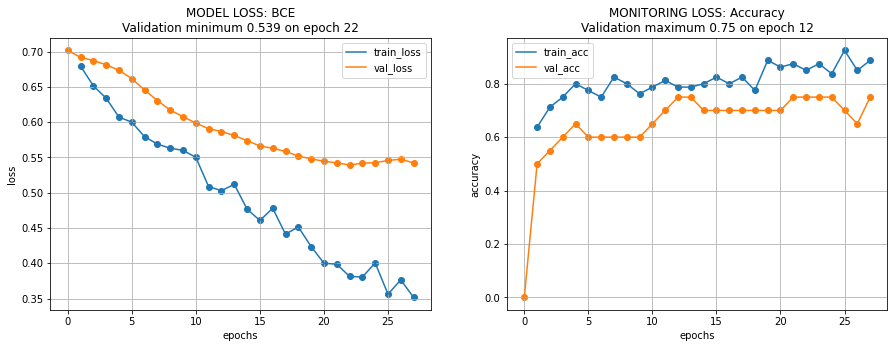

In [12]:
dataloader = ParrotDataLoader.create_loader(**config['dataloader'])
model_resnet18 = ParrotModel(**config['model'])

checkpoint = ModelCheckpoint(dirpath='checkpoint/', monitor='val_loss', mode='min')
callbacks = [
        EarlyStopping('val_loss', min_delta=0.001, patience=5, mode='min'), 
        checkpoint,
    ]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)
trainer.fit(model_resnet18, dataloader)

In [13]:
model_resnet18 = ParrotModel.load_from_checkpoint(checkpoint.best_model_path)

Из полученных результатов видно, что имеет место переобучение модели. Оценка на валидации значительно отстает от оценки на тренировочном наборе данных.

Фиксируем лучшую оценку BCE и Accuracy на валидации: 0.539 и 0.75 соответственно. Неплохо, но можно и лучше.

### 3.2 Проверка работы модели ResNet18 с разными типами аугментации

Попробуем добавить следующие типы аугментации:
- случайный горизонтальный поворот;
- смещение RGB;
- случайное изменение яркости и контрастности.

In [14]:
config['dataloader']['dataset_params']['val_transforms'] = BaseImageTransform()
train_transforms = BaseImageTransform()

transforms_to_add = A.Compose([
    A.Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
    A.HorizontalFlip(p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.4, contrast_limit=0.4),
])

for idx, new_transform in enumerate(transforms_to_add):
    if idx == 0:
        continue
    train_transforms.add_transform(new_transform, idx)
   

config['dataloader']['dataset_params']['train_transforms'] = train_transforms

dataloader = ParrotDataLoader.create_loader(**config['dataloader'])   

print("===============================")
print("Преобразования для обучения")
print("===============================")
print(dataloader.train_dataset._train_transforms)
print("===============================")
print("Преобразования для валидации")
print("===============================")
print(dataloader.val_dataset._val_transforms)

Преобразования для обучения
Compose([
  Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.5),
  RGBShift(always_apply=False, p=0.5, r_shift_limit=(-15, 15), g_shift_limit=(-15, 15), b_shift_limit=(-15, 15)),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.4, 0.4), contrast_limit=(-0.4, 0.4), brightness_by_max=True),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
Преобразования для валидации
Compose([
  Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=

Примеры аугментированных изображений


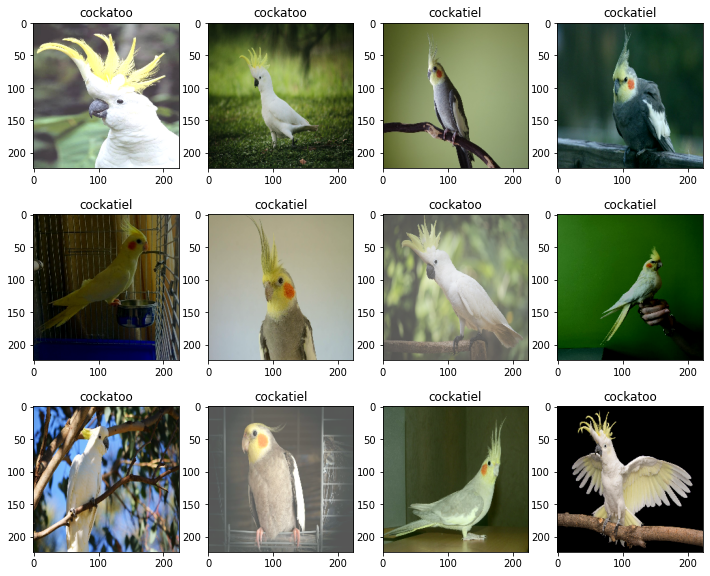

In [15]:
print("===============================")
print("Примеры аугментированных изображений")
print("===============================")
print_aug_img(dataloader, transforms_to_add)

И заново обучим модель

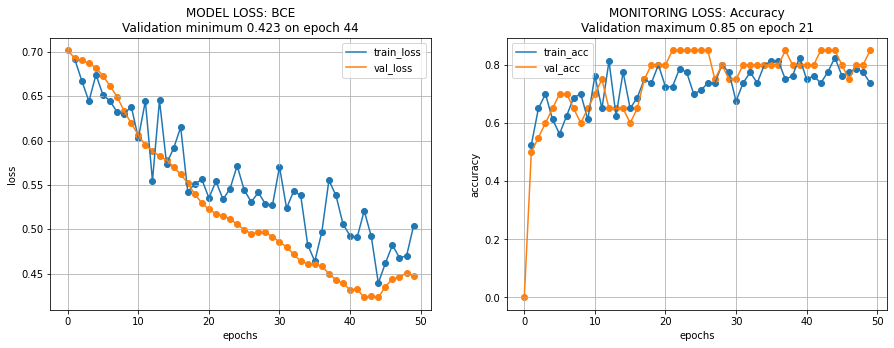

In [16]:
model_resnet18_aug1 = ParrotModel(**config['model'])

checkpoint = ModelCheckpoint(dirpath='checkpoint/', monitor='val_loss', mode='min')
callbacks = [
        EarlyStopping('val_loss', min_delta=0.0001, patience=5, mode='min'), 
        checkpoint,
    ]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)
trainer.fit(model_resnet18_aug1, dataloader)

In [17]:
model_resnet18_aug1 = ParrotModel.load_from_checkpoint(checkpoint.best_model_path)

После добавления аугментации заметно, что модель больше не переобучается. А скачки метрики на валидации можно объяснить тем, что у нас достаточно широкий разброс по яркости и контрастности во время генерации аугментированных изображений, а такие изображения для модели получают большую степень неизвестности для модели. Но это позитивно влияет на результат валидации.

Фиксируем лучшую оценку BCE и Accuracy на валидации: 0.432 и 0.85 соответственно. Мы смогли улучшить обе метрики на 0.1.

Теперь попробуем добавить Cutout.

In [18]:
config['dataloader']['dataset_params']['val_transforms'] = BaseImageTransform()
train_transforms = BaseImageTransform()

transforms_to_add = A.Compose([
    A.Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
    A.HorizontalFlip(p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.4, contrast_limit=0.4),
    A.Cutout(num_holes=1, max_h_size=60, max_w_size=60),
])

for idx, new_transform in enumerate(transforms_to_add):
    if idx == 0:
        continue
    train_transforms.add_transform(new_transform, idx)
   

config['dataloader']['dataset_params']['train_transforms'] = train_transforms

dataloader = ParrotDataLoader.create_loader(**config['dataloader'])   

print("===============================")
print("Преобразования для обучения")
print("===============================")
print(dataloader.train_dataset._train_transforms)
print("===============================")
print("Преобразования для валидации")
print("===============================")
print(dataloader.val_dataset._val_transforms)

Преобразования для обучения
Compose([
  Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
  HorizontalFlip(always_apply=False, p=0.5),
  RGBShift(always_apply=False, p=0.5, r_shift_limit=(-15, 15), g_shift_limit=(-15, 15), b_shift_limit=(-15, 15)),
  RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.4, 0.4), contrast_limit=(-0.4, 0.4), brightness_by_max=True),
  Cutout(always_apply=False, p=0.5, num_holes=1, max_h_size=60, max_w_size=60),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})
Преобразования для валидации
Compose([
  Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=

C:\ProgramData\Anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Примеры аугментированных изображений


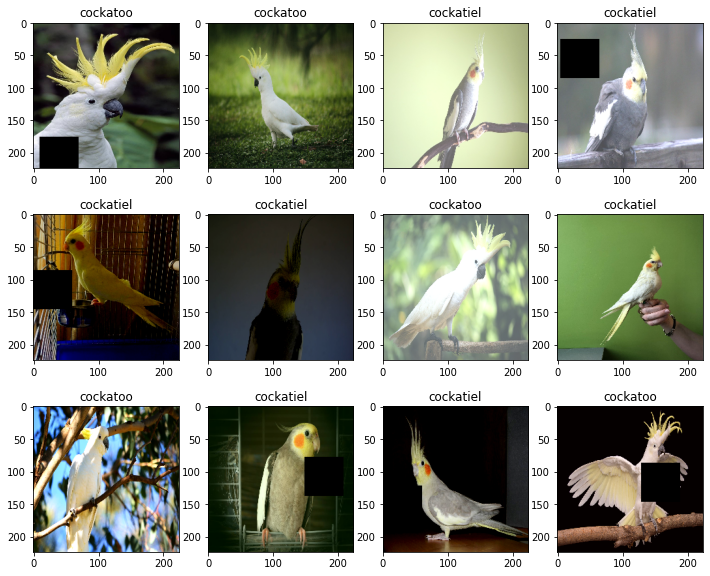

In [19]:
print("===============================")
print("Примеры аугментированных изображений")
print("===============================")
print_aug_img(dataloader, transforms_to_add)

И заново обучим модель.

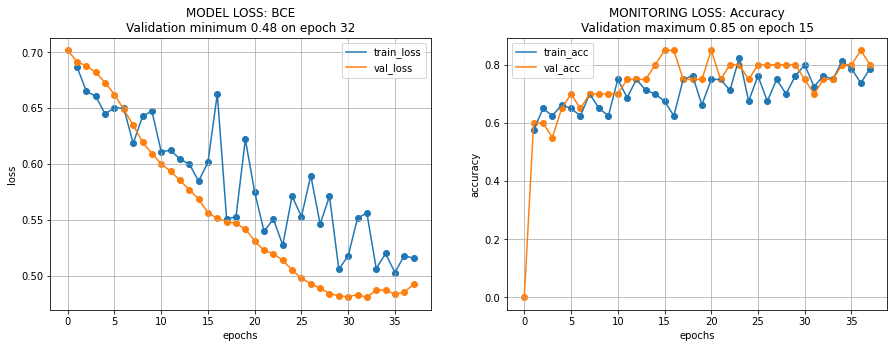

In [20]:
model_resnet18_aug2 = ParrotModel(**config['model'])

checkpoint = ModelCheckpoint(dirpath='checkpoint/', monitor='val_loss', mode='min')
callbacks = [
        EarlyStopping('val_loss', min_delta=0.0001, patience=5, mode='min'), 
        checkpoint,
    ]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)
trainer.fit(model_resnet18_aug2, dataloader)

In [21]:
model_resnet18_aug2 = ParrotModel.load_from_checkpoint(checkpoint.best_model_path)

С текущими настройками Cutout не смог улучшить качество модели. Далее будем использовать модель без Cutout.

### 3.3 Проверка работы модели ResNet18 с лучшей аугментацией и BYOL

Теперь попробуем инициализировать веса для модели ResNet18 с помощью BYOL.

In [22]:
config['dataloader']['dataset_params']['val_transforms'] = BaseImageTransform()
train_transforms = BaseImageTransform()

transforms_to_add = A.Compose([
    A.Resize(always_apply=False, p=1, height=224, width=224, interpolation=1),
    A.HorizontalFlip(p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5, brightness_limit=0.4, contrast_limit=0.4),
])

for idx, new_transform in enumerate(transforms_to_add):
    if idx == 0:
        continue
    train_transforms.add_transform(new_transform, idx)
   

config['dataloader']['dataset_params']['train_transforms'] = train_transforms

dataloader = ParrotDataLoader.create_loader(**config['dataloader'])   

model_resnet_18_aug1_byol = ParrotModel(**config['model'])

learner = BYOL(
    model_resnet_18_aug1_byol,
    image_size = 224,
    hidden_layer = '_model.global_pool'
)

opt = torch.optim.Adam(learner.parameters(), lr=0.0001)

for _ in tqdm(range(10)):
    for batch in tqdm(dataloader.train_dataloader()):
        loss = learner(batch['img'])
        opt.zero_grad()
        loss.backward()
        opt.step()
        learner.update_moving_average() # update moving average of target encoder

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

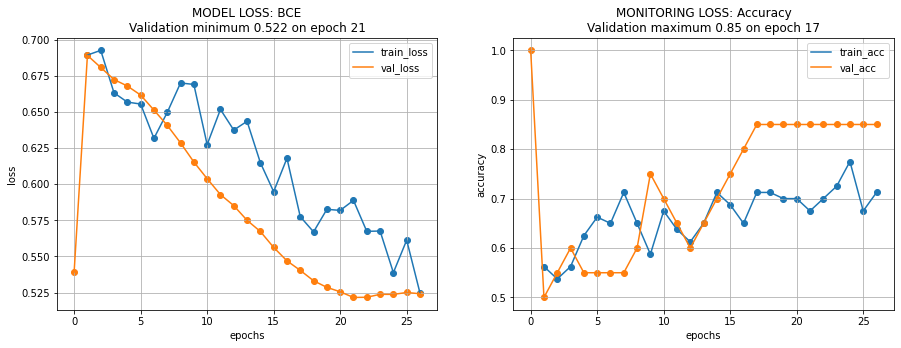

In [23]:
dataloader = ParrotDataLoader.create_loader(**config['dataloader'])

checkpoint = ModelCheckpoint(dirpath='checkpoint/', monitor='val_loss', mode='min')
callbacks = [
        EarlyStopping('val_loss', min_delta=0.001, patience=5, mode='min'), 
        checkpoint,
    ]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)
trainer.fit(model_resnet_18_aug1_byol, dataloader)

In [24]:
model_resnet_18_aug1_byol = ParrotModel.load_from_checkpoint(checkpoint.best_model_path)

Из графиков видно, что не удалось добиться значительного улучшения и результат по ошибке ВСЕ получился хуже примерно на 0.1. 

## 4 Итоги

Были протестированы следующие модели:
1. ResNet18 без аугментации: BCE 0.539 и Accuracy 0.75
1. ResNet18 + Аугментация (случайный горизонтальный поворот, смещение RGB, случайное изменение яркости и контрастности): BCE 0.539 и Accuracy 0.75
1. ResNet18 + Аугментация (cutout, случайный горизонтальный поворот, смещение RGB, случайное изменение яркости и контрастности): BCE 0.48 и Accuracy 0.85
1. ResNet18 + BYOL + Аугментация (cutout, случайный горизонтальный поворот, смещение RGB, случайное изменение яркости и контрастности): BCE 0.522 и Accuracy 0.85

По результатам исследования лучшей моделью является модель номер 2.

Построим предсказания данной модели на валидационной части.

In [25]:
def predict_model(model, batch):
    predict = model(batch['img'], sigmoid=True).flatten()
    predict = np.where(predict.cpu() < 0.5, 0, 1)
    return predict

In [26]:
def print_val_images(model, dataloader):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    
    model.eval()
    
    backup_batch_size = dataloader.val_loader_params['batch_size']
    dataloader.val_loader_params['batch_size'] = 1
    
    y_pred = []
    y_true = []
    
    fig, axes = plt.subplots(5, 4, figsize=(12, 18))
    axes = axes.flatten()

    for index, val_data in enumerate(dataloader.val_dataloader()):

        target_parrot_name = val_data['parrot_name'][0]
        y_true.append(val_data['target'][0].item())
        val_data['img'] = val_data['img'].to(device)

        predict = predict_model(model, val_data)[0]
        y_pred.append(predict.item())
        
        if index >= len(axes):
            continue

        predict_parrot_name = 'cockatiel' if predict == 0 else 'cockatoo'
        
        img_source = cv2.imread(val_data['image_path'][0], cv2.IMREAD_COLOR)
        img_source = cv2.resize(img_source, dsize=(128,128))
        img_source = cv2.cvtColor(img_source, cv2.COLOR_BGR2RGB)
        axes[index].imshow(img_source)
        axes[index].set_title(f"target: {target_parrot_name}\npred: {predict_parrot_name}")
        
    print('Accuracy Score:', accuracy_score(y_true, y_pred))
    plt.show()
    
    dataloader.val_loader_params['batch_size'] = backup_batch_size

Accuracy Score: 0.85


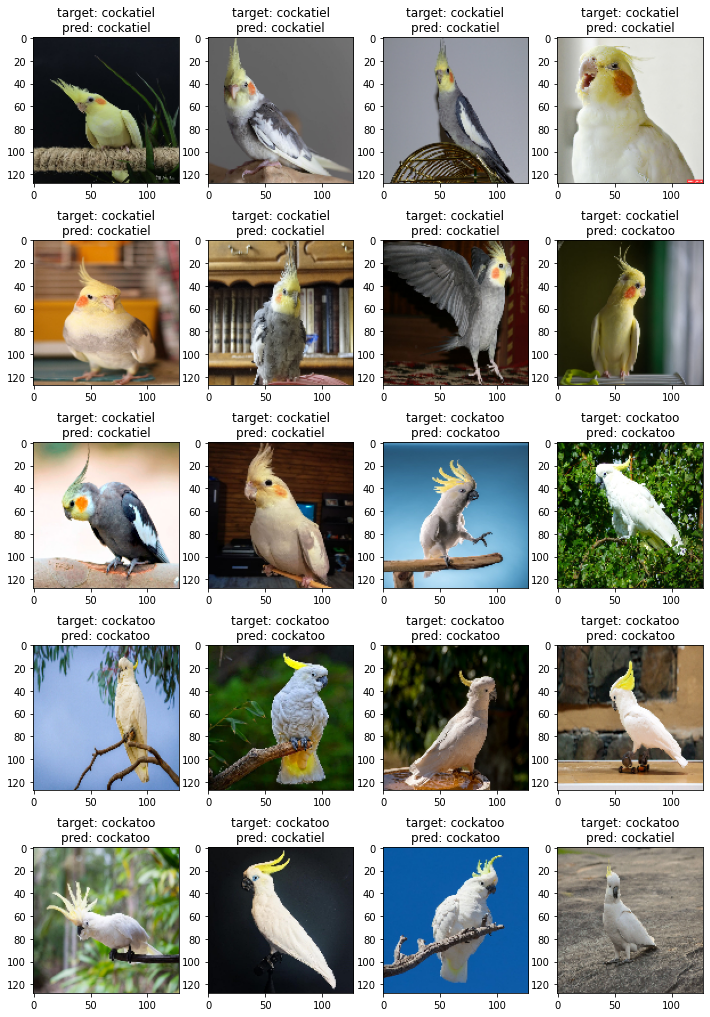

In [27]:
print_val_images(model_resnet18_aug1, dataloader)